# Week 8 - Capstone Project

- Day 50 - Choose Dataset
- Day 51 - EDA
- Day 52 - Data Cleaning + Features
- Day 53 - Modeling
- Day 54 - Evaluation
- Day 55 - Report + Slides
- Day 56 - Publish

Template
1. Load
2. EDA
3. Preprocess
4. Baseline
5. Tree model
6. AUC/PR - AUC
7. Calibration
8. Thresholding/code
9. Explainability
10. Bootstrap CI

## Day 50 - Choose Dataset
- Pick one project
- Define problem
- Set up folder -> collect dataset

In [1]:
# Dataset: Credit Risk Modeling (UCI id=350)

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#%pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss, 
    RocCurveDisplay, PrecisionRecallDisplay, log_loss, 
    confusion_matrix, ConfusionMatrixDisplay,
    make_scorer
)

from sklearn.inspection import permutation_importance
import joblib



In [2]:
RANDOM_STATE=42 

In [3]:
# 1. Load data

ds = fetch_ucirepo(id=350) # Default of Credit Card Clients
df = ds.data.features
df.head()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [4]:

# Data dictionary (if provided)
vars_df = ds.variables  # pandas DataFrame
display(vars_df.head(30))
print(vars_df.columns)

,name,role,type,demographic,description,units,missing_values
0,ID,ID,Integer,None,None,None,no
1,X1,Feature,Integer,None,LIMIT_BAL,None,no
2,X2,Feature,Integer,Sex,SEX,None,no
3,X3,Feature,Integer,Education Level,EDUCATION,None,no
4,X4,Feature,Integer,Marital Status,MARRIAGE,None,no
5,X5,Feature,Integer,Age,AGE,None,no
6,X6,Feature,Integer,None,PAY_0,None,no
7,X7,Feature,Integer,None,PAY_2,None,no
8,X8,Feature,Integer,None,PAY_3,None,no
9,X9,Feature,Integer,None,PAY_4,None,no


Index(['name', 'role', 'type', 'demographic', 'description', 'units',
       'missing_values'],
      dtype='object')


Meaning for the features
- PAY_0, PAY_1,...PAY_6: repayment status in Sep 2025, Aug 2025...Apr 2025
    - -1: paid on time; 
    - -2: no consumption / card not used in that month; 
    - 0: revolving credit (paid the minimum / carrying a balance)
    - 1: pmt delay for 1 month; 2: delay for 2 months;...9: delay for 9 months
- BILL_AMT1, BILL_AMT2, ... BILL_AMT6: bill statement amounts for Sep 2025, Aug 2025, ... Apr 2025
- PAY_AMT1, ... Amounts actually paid for those monthss
- SEX: 1=male; 2=female
- EDUCATION: 1=graduate school; 2=university; 3=high school; 4=others
- MARRIAGE: 1=married; 2=single; 3=others; 0,5,6=unknown/others
- Y: default next month? - 1 yes; 2 no
    - yes: the person fails to make the required pmt when it's due in the following month





In [5]:
key_col = "name" if "name" in vars_df.columns else None
desc_col = "description"

if key_col is not None:
    name_to_desc = vars_df.set_index(key_col)[desc_col].to_dict() # selects just the description column from that indexed DataFrame.
else:
    # Fallback: assume vars_df.index already matches df column names
    name_to_desc = vars_df[desc_col].to_dict()

# 1) Use descriptions as df COLUMN NAMES
df_desc_cols = df.rename(columns=lambda c: name_to_desc.get(c, c)) #name_to_desc.get(c,c) If c exists as a key in name_to_desc, return name_to_desc[c] (the description).

# 2) Use descriptions as df INDEX (only works if df.index labels match the same keys)
#df_desc_index = df.rename(index=lambda i: name_to_desc.get(i, i))


In [6]:
df_desc_cols.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [7]:
df_desc_cols.shape


(30000, 23)

In [8]:
df_new = df_desc_cols.copy()

In [9]:
X = df_new.copy()
y = ds.data.targets.copy()

# y might come as a DF with one column
if isinstance(y, pd.DataFrame):
    if y.shape[1] != 1:
        raise ValueError(f"Expected single target column, got {list(y.column)}")
    y = y.iloc[:,0]

# Ensure y is numeric 0/1
y = pd.to_numeric(y, errors="raise").astype(int) #errors - what pandas do when encounter special values - eg. "unknown", "NA"

print("X shape:", X.shape)
print("y positive rate:", y.mean())





X shape: (30000, 23)
y positive rate: 0.2212


In [10]:
TEST_SIZE=0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = TEST_SIZE, 
    stratify=y, 
    random_state=RANDOM_STATE
)

## Day 51 - EDA
- Explore features
- visualize patterns 
- correlations

In [11]:
X_train.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [12]:
exclude = ["SEX", "EDUCATION", "MARRIAGE"]
num_cols = X_train.columns.difference(exclude).tolist()

# If ID exists, remove from numeric EDA
if "ID" in num_cols:
    num_cols.remove("ID")

print("\nNumeric summary:\n", X_train[num_cols].describe().T)


Numeric summary:
              count           mean            std       min       25%  \
AGE        24000.0      35.432625       9.195256      21.0     28.00   
BILL_AMT1  24000.0   51100.502250   73510.032060 -165580.0   3513.75   
BILL_AMT2  24000.0   49012.267583   70840.102410  -69777.0   2989.75   
BILL_AMT3  24000.0   46861.880083   68403.933692  -61506.0   2652.00   
BILL_AMT4  24000.0   43156.661458   64046.730878  -81334.0   2332.00   
BILL_AMT5  24000.0   40164.412625   60627.850612  -81334.0   1746.00   
BILL_AMT6  24000.0   38675.979875   59308.737828 -339603.0   1225.00   
LIMIT_BAL  24000.0  167364.666667  129511.313151   10000.0  50000.00   
PAY_0      24000.0      -0.014125       1.123155      -2.0     -1.00   
PAY_2      24000.0      -0.134083       1.198818      -2.0     -1.00   
PAY_3      24000.0      -0.166917       1.194166      -2.0     -1.00   
PAY_4      24000.0      -0.221333       1.161924      -2.0     -1.00   
PAY_5      24000.0      -0.270333       1.125

In [13]:
train_df = X_train.copy()
train_df["target"] = y_train.to_numpy() # or train_df["target"] = y_train
train_df = pd.concat([y_train.rename("target"), X_train], axis=1)

target
0    18691
1     5309
Name: count, dtype: int64


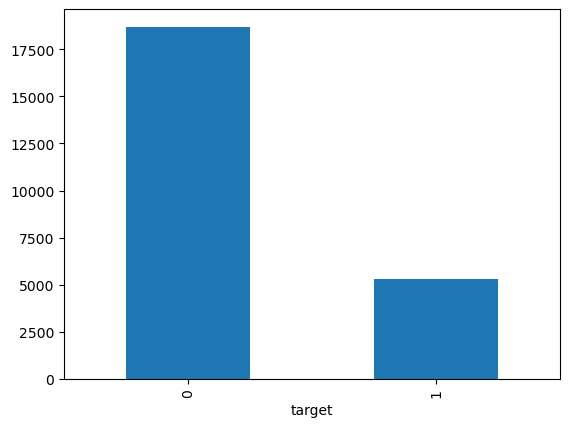

In [14]:
target_col = "target"
print(train_df[target_col].value_counts(dropna=False))
train_df[target_col].value_counts().plot(kind="bar")
plt.show()


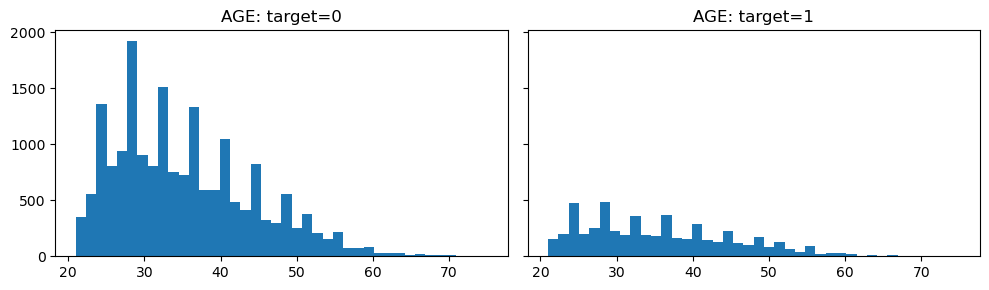

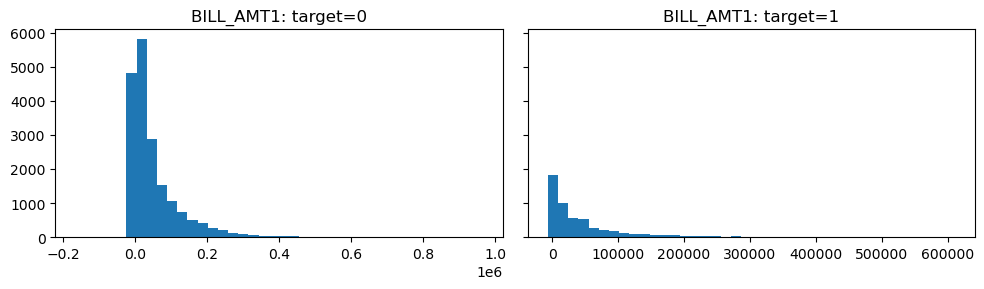

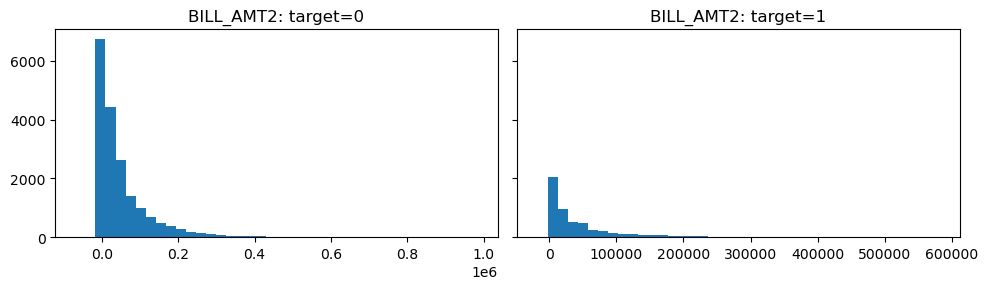

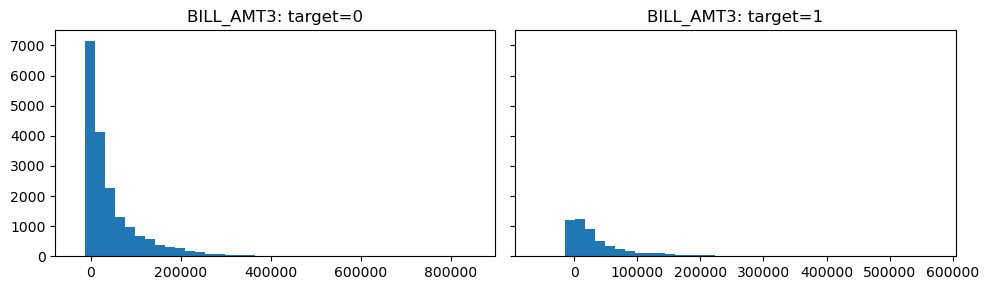

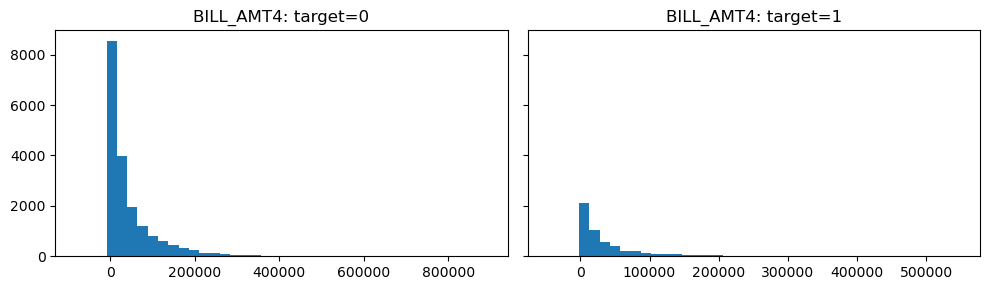

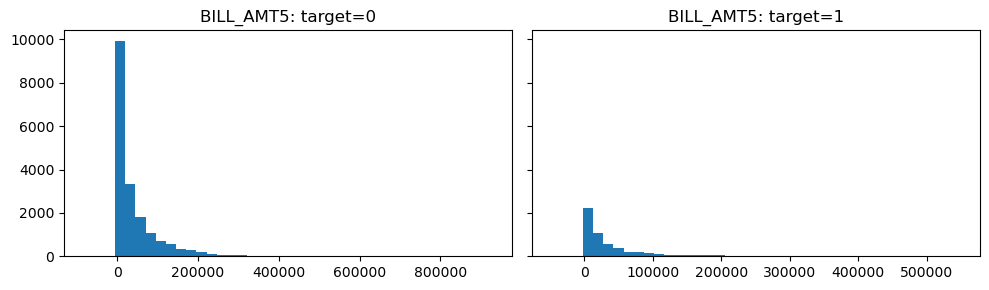

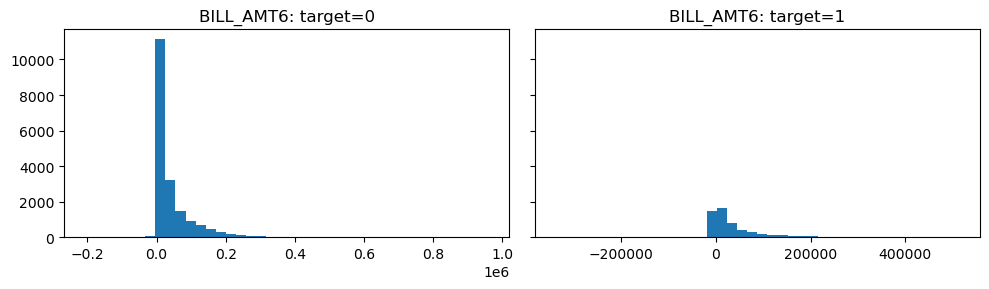

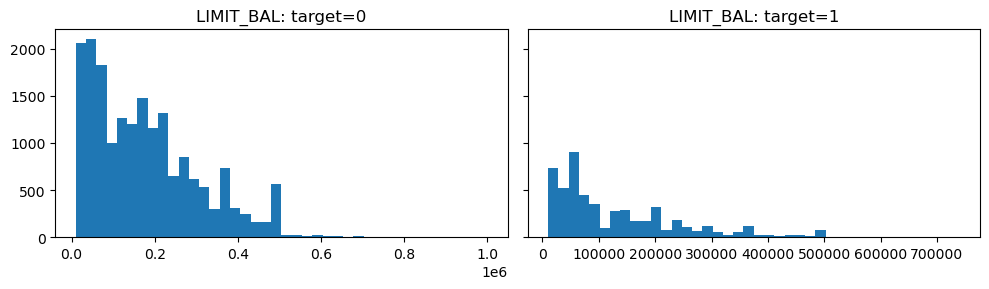

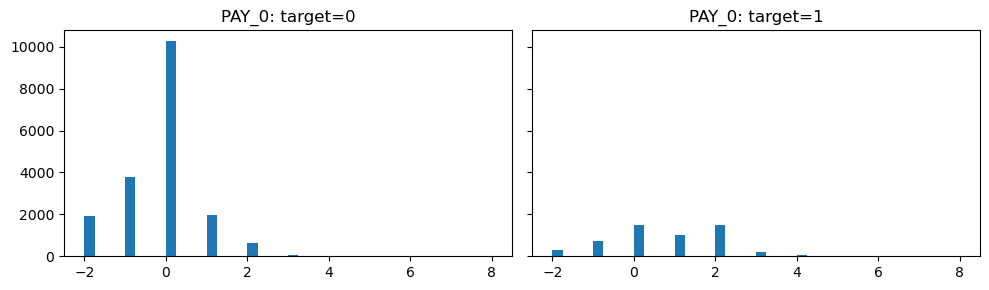

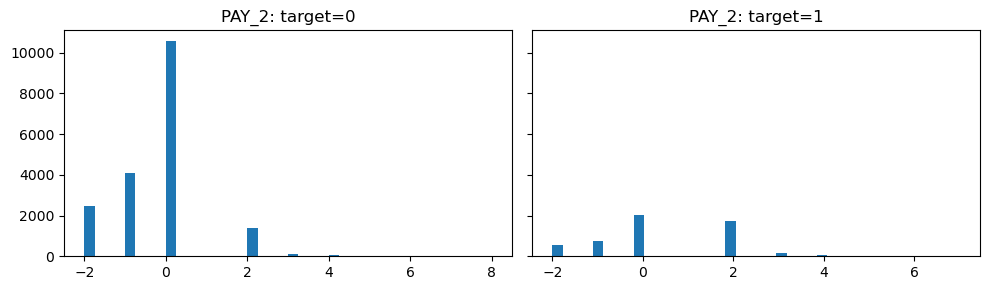

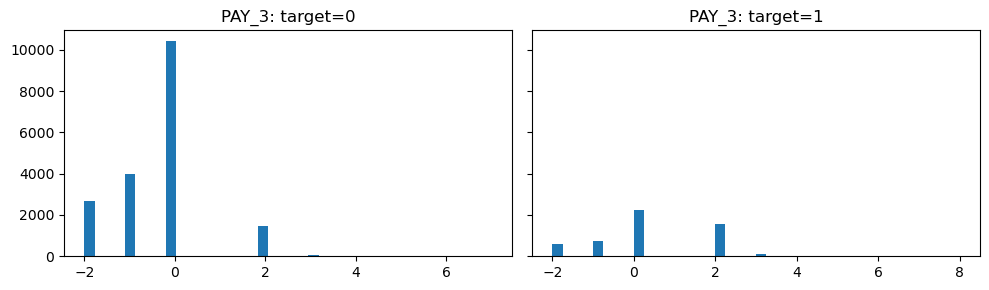

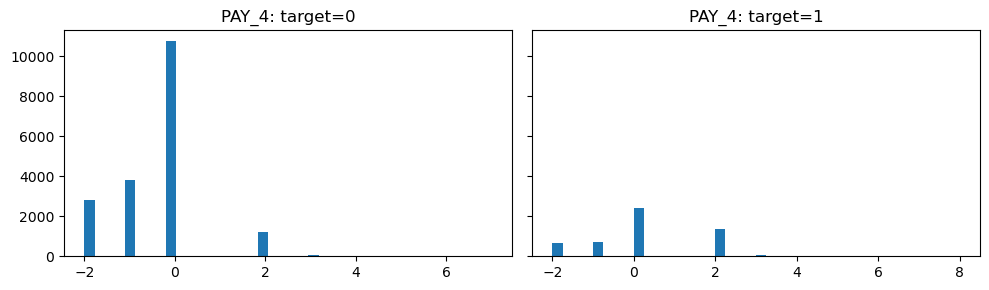

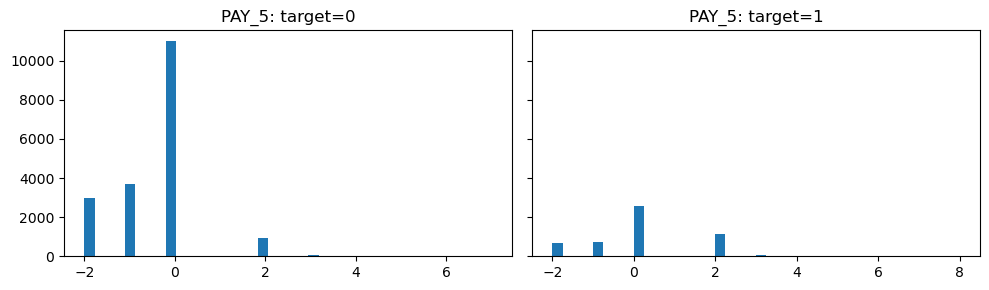

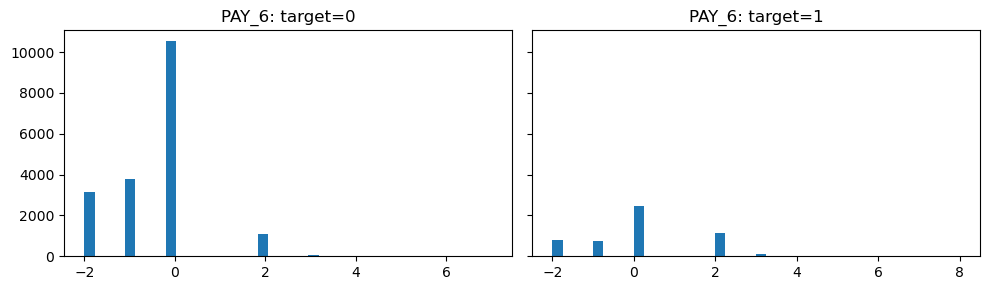

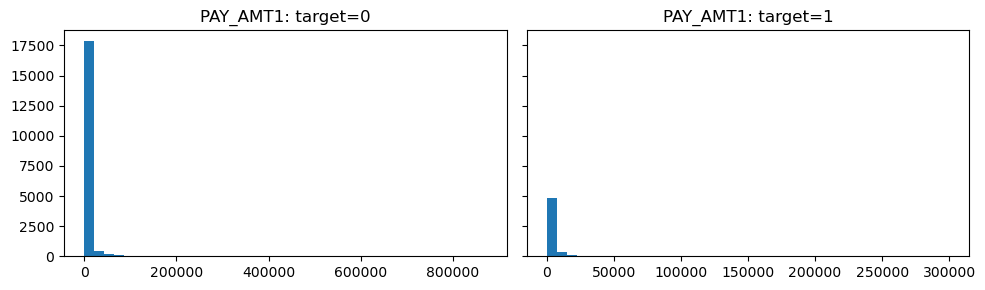

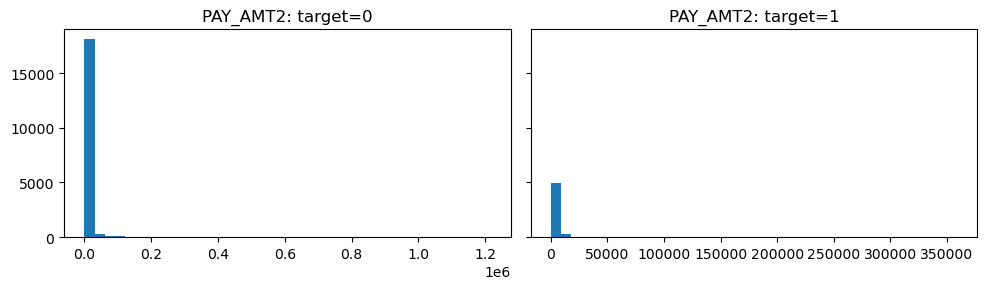

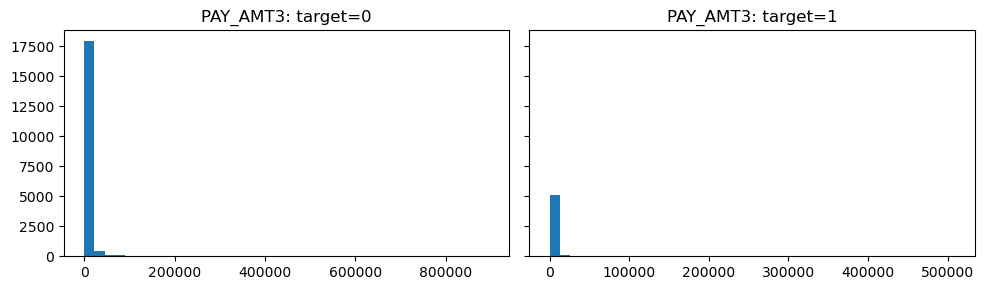

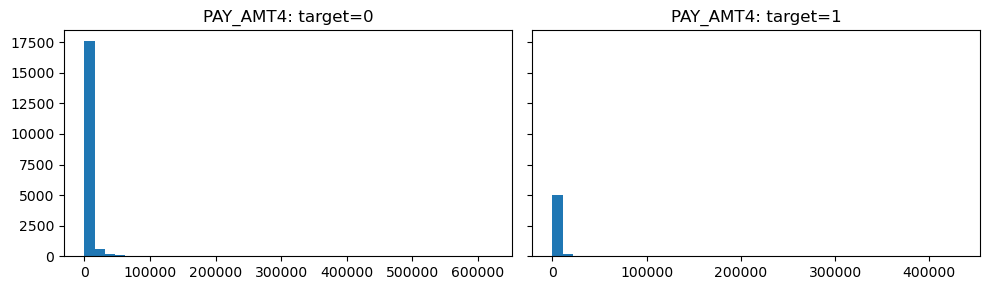

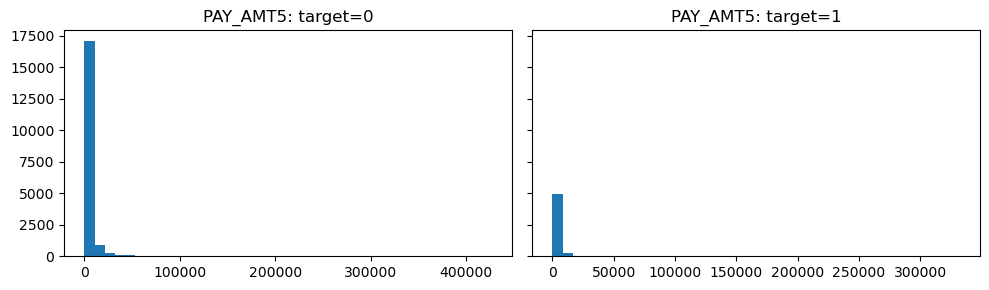

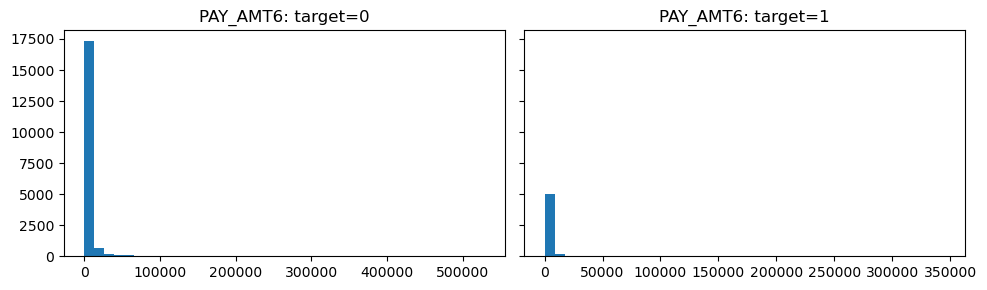

In [15]:
def plot_feature_histograms_split_by_target(
    data, cols, target_col, bins=40, layout="side_by_side"
):
    cols = [c for c in cols if c in data.columns and c != target_col]

    for c in cols:
        s0 = data.loc[data[target_col] == 0, c].dropna()
        s1 = data.loc[data[target_col] == 1, c].dropna()

        if layout == "side_by_side":
            fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
            axes[0].hist(s0, bins=bins)
            axes[0].set_title(f"{c}: {target_col}=0")
            axes[1].hist(s1, bins=bins)
            axes[1].set_title(f"{c}: {target_col}=1")
            plt.tight_layout()
            plt.show()

        elif layout == "overlay":
            plt.figure(figsize=(6, 4))
            plt.hist(s0, bins=bins, alpha=0.6, label=f"{target_col}=0")
            plt.hist(s1, bins=bins, alpha=0.6, label=f"{target_col}=1")
            plt.title(c)
            plt.legend()
            plt.tight_layout()
            plt.show()



plot_feature_histograms_split_by_target(train_df, num_cols, target_col="target", bins=40, layout="side_by_side")
# or: layout="overlay"



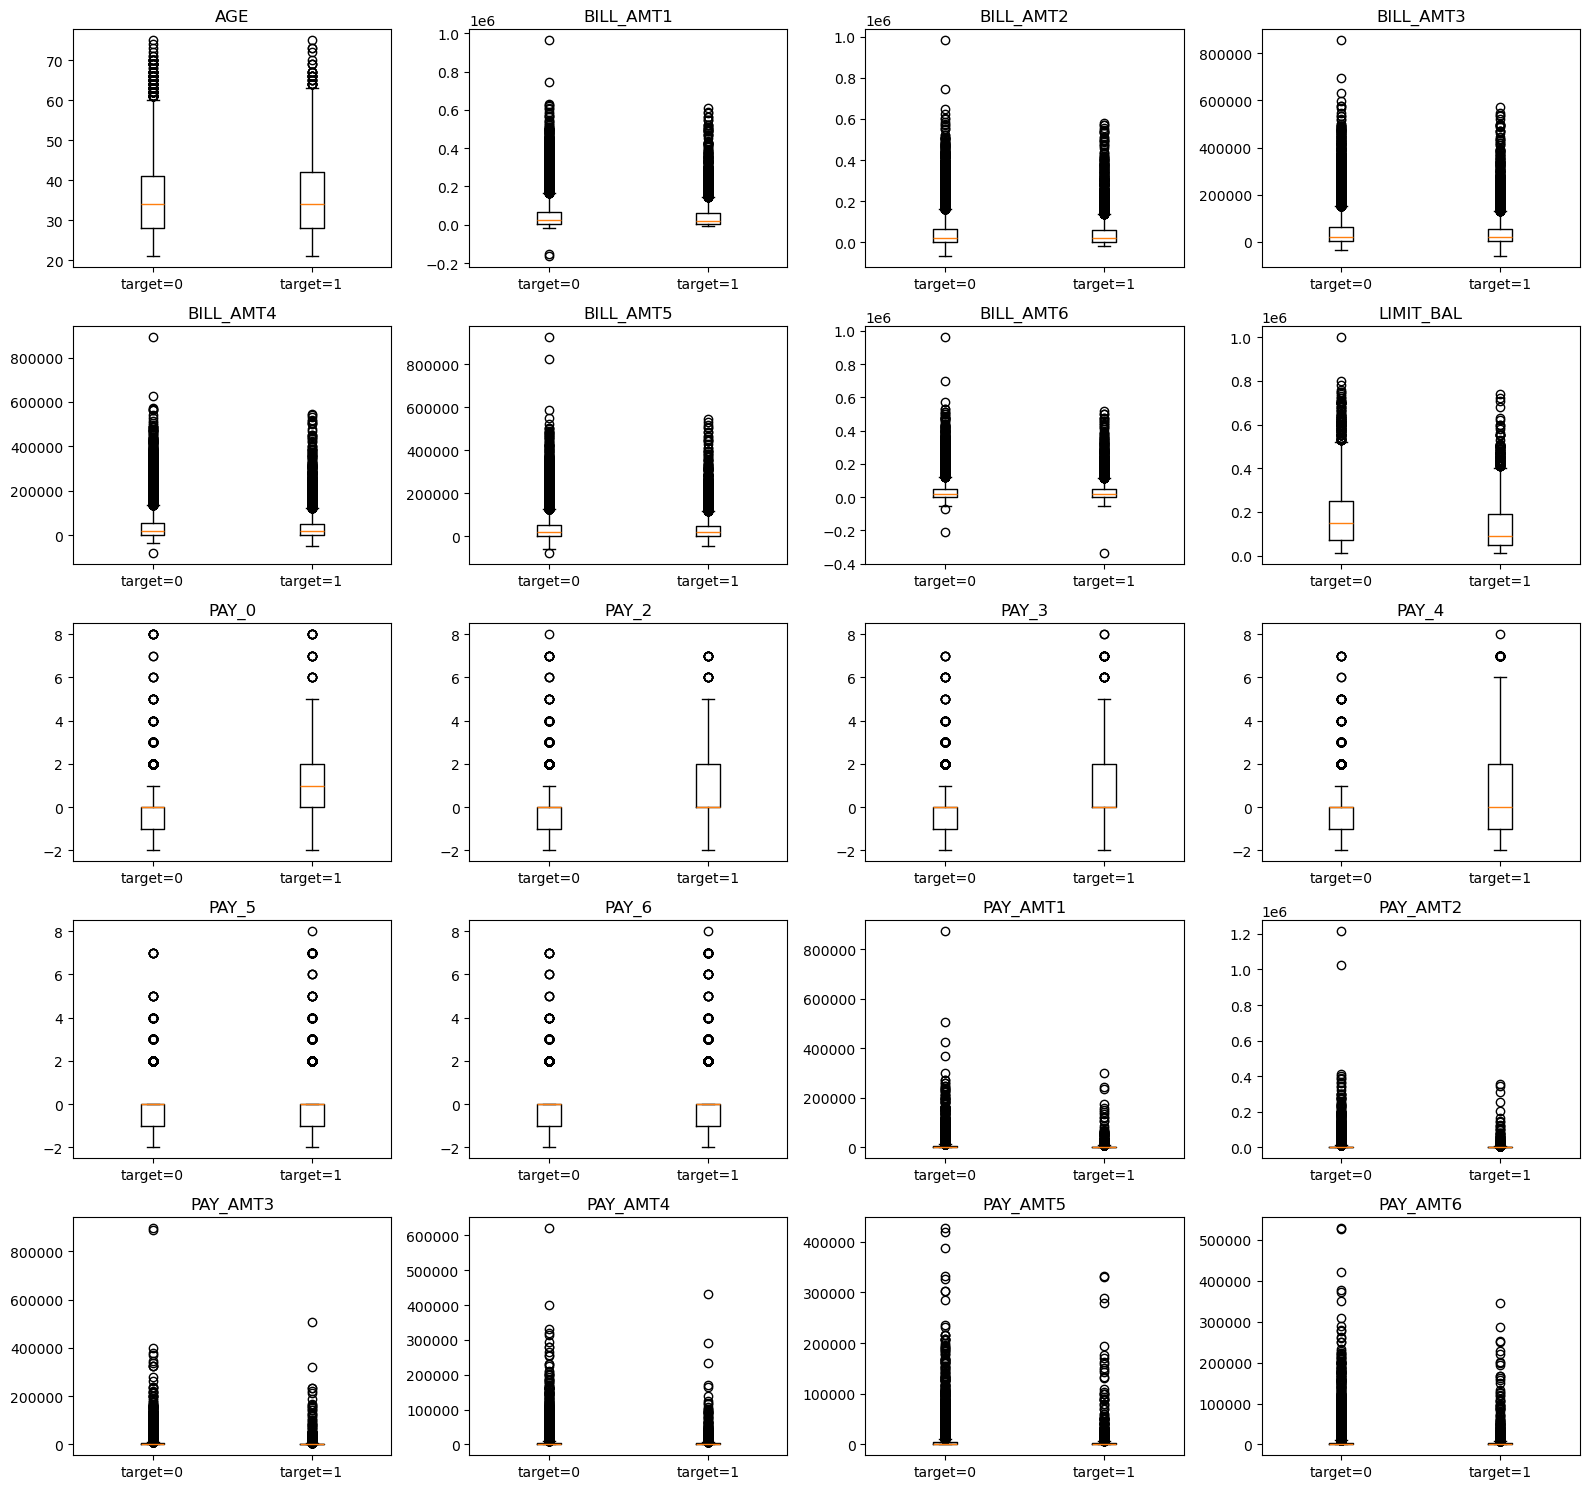

In [16]:
def plot_boxplots_split_by_target(df, cols, target_col, cols_per_row=4):
    n = len(cols)
    nrows = int(np.ceil(n / cols_per_row))
    plt.figure(figsize=(4 * cols_per_row, 3 * nrows))

    for i, c in enumerate(cols, 1):
        plt.subplot(nrows, cols_per_row, i)
        g0 = df.loc[df[target_col] == 0, c].dropna()
        g1 = df.loc[df[target_col] == 1, c].dropna()

        plt.boxplot([g0,g1], tick_labels=[f"{target_col}=0", f"{target_col}=1"], vert=True)
        plt.title(c)
    plt.tight_layout()
    plt.show()


plot_boxplots_split_by_target(train_df, num_cols, target_col="target")


SEX value counts:
 SEX
1     9486
2    14514
Name: count, dtype: int64


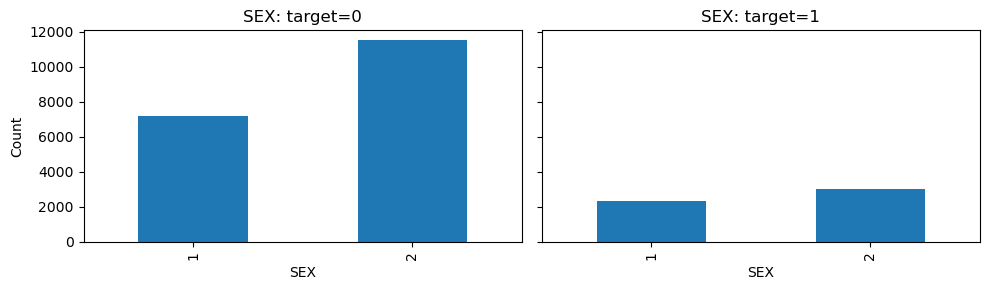


EDUCATION value counts:
 EDUCATION
0       12
1     8455
2    11256
3     3903
4       97
5      235
6       42
Name: count, dtype: int64


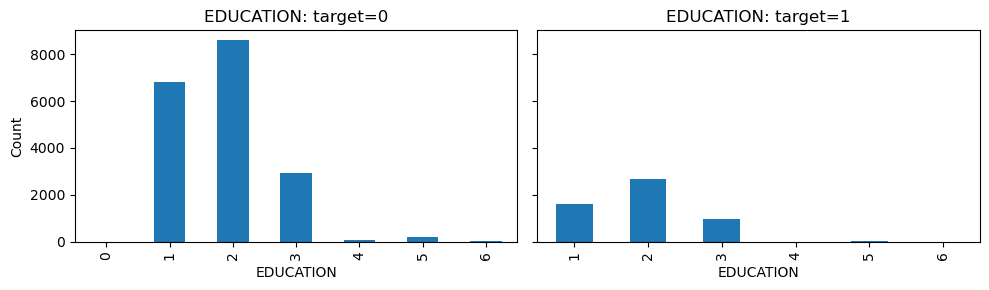


MARRIAGE value counts:
 MARRIAGE
0       47
1    10892
2    12806
3      255
Name: count, dtype: int64


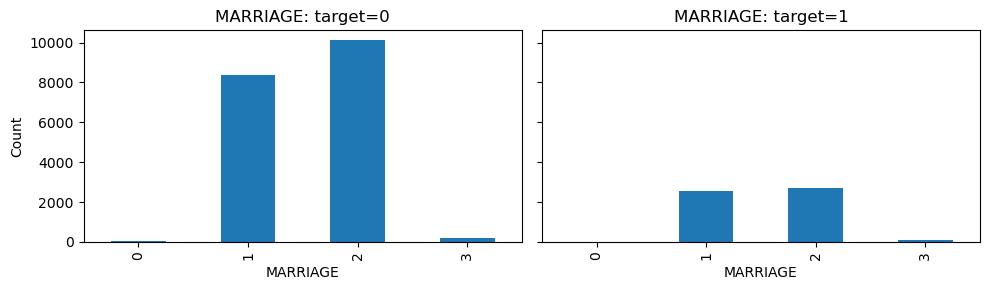

In [17]:
cat_like = [c for c in ["SEX", "EDUCATION", "MARRIAGE"] if c in train_df.columns]
target_col = "target"

for c in cat_like:
    print(f"\n{c} value counts:\n", train_df[c].value_counts(dropna=False).sort_index())

    fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

    for ax, t in zip(axes, [0, 1]):
        vc = train_df.loc[train_df[target_col] == t, c].value_counts(dropna=False).sort_index()
        vc.plot(kind="bar", ax=ax)
        ax.set_title(f"{c}: {target_col}={t}")
        ax.set_xlabel(c)
        ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


Default rate by SEX: 
 SEX
1    0.243728
2    0.206490
Name: target, dtype: float64


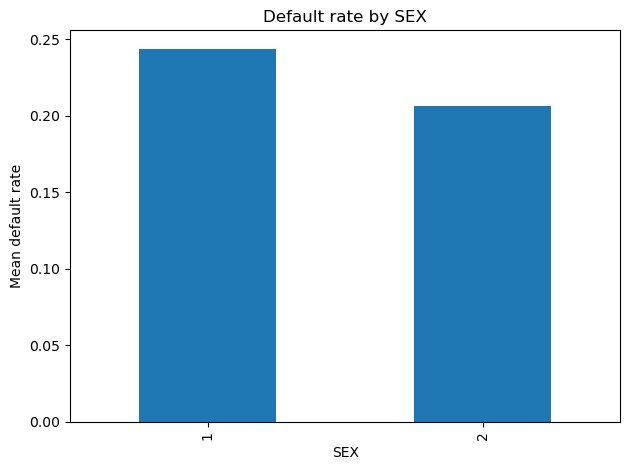


Default rate by EDUCATION: 
 EDUCATION
0    0.000000
1    0.192904
2    0.237562
3    0.250064
4    0.061856
5    0.063830
6    0.166667
Name: target, dtype: float64


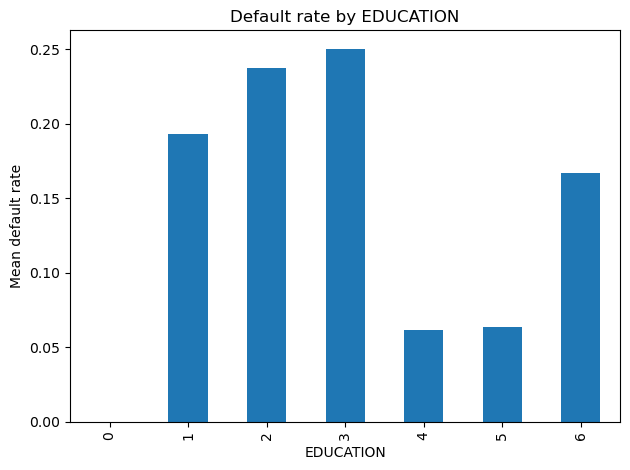


Default rate by MARRIAGE: 
 MARRIAGE
0    0.106383
1    0.233015
2    0.210370
3    0.282353
Name: target, dtype: float64


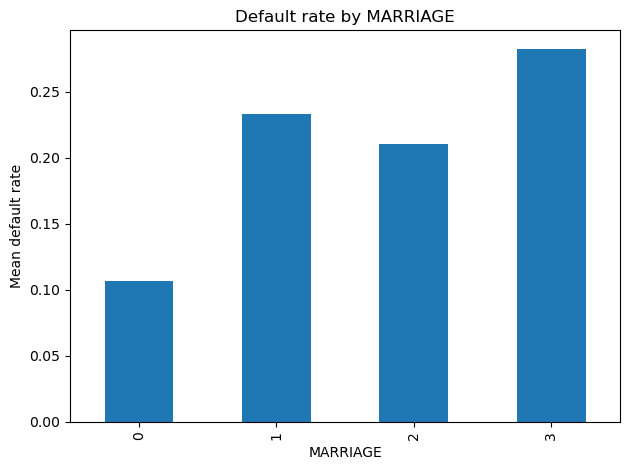

In [18]:
# Default rate by category 
if target_col in train_df.columns:
    for c in cat_like:
        rate = train_df.groupby(c)[target_col].mean().sort_index()
        print(f"\nDefault rate by {c}: \n", rate)
        rate.plot(kind="bar")
        plt.title(f"Default rate by {c}")
        plt.xlabel(c)
        plt.ylabel("Mean default rate")
        plt.tight_layout()
        plt.show()


PAY_* columns: ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']


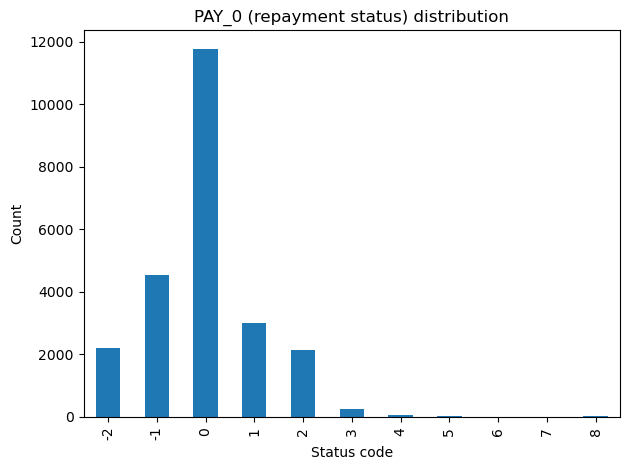

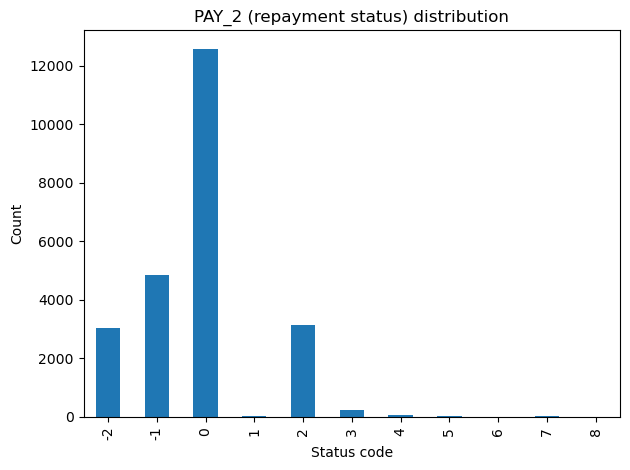

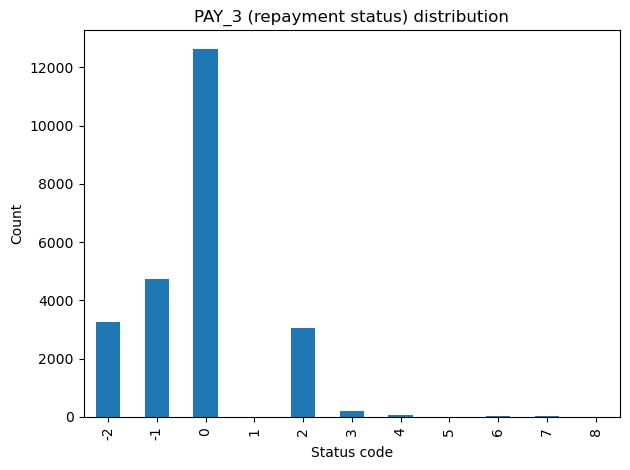

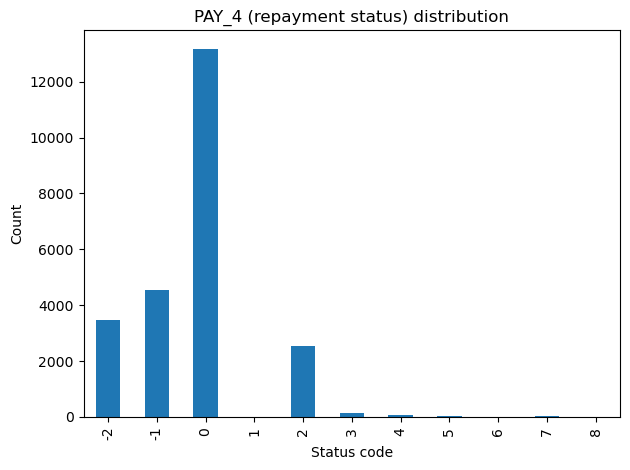

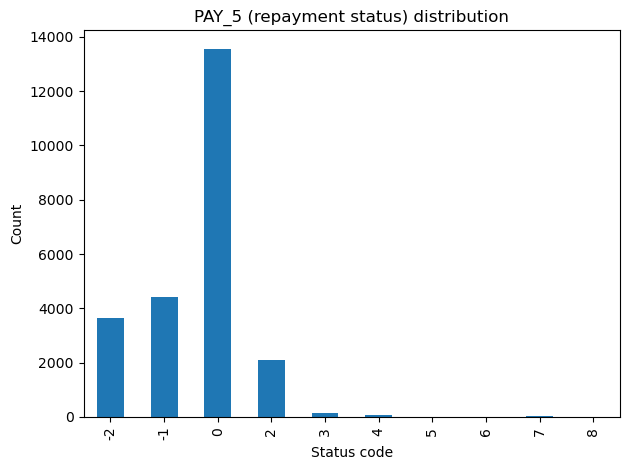

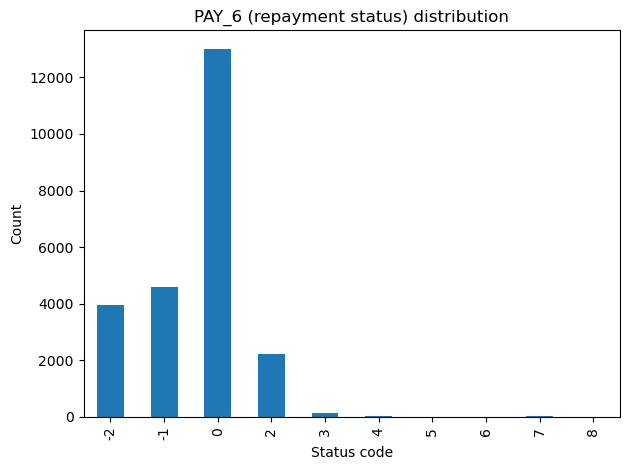

In [19]:
# PAY_* delinquency code distributions + "max deliquency" insight
pay_cols = [c for c in train_df.columns if c.startswith("PAY_") and not c.startswith("PAY_AMT")]
if pay_cols: 
    print("\nPAY_* columns:", pay_cols)
    # Distribution per PAY column (bar charts)
    for c in pay_cols:
        train_df[c].value_counts().sort_index().plot(kind="bar")
        plt.title(f"{c} (repayment status) distribution")
        plt.xlabel("Status code")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

   



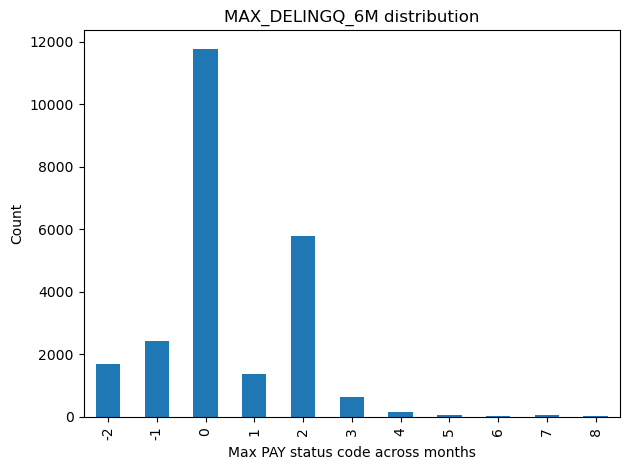

In [20]:
if pay_cols:
     # A quick "overall delinquency severity" feature (for EDA insight)
    train_df["MAX_DELINQ_6M"] = train_df[pay_cols].max(axis=1)
    train_df["MAX_DELINQ_6M"].value_counts().sort_index().plot(kind="bar")
    plt.title("MAX_DELINGQ_6M distribution")
    plt.xlabel("Max PAY status code across months")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# MAX_DELINQ_6M = the worst deliquency status code observed across the 6 months



Default rate by MAX_DELINQ_6M:
 MAX_DELINQ_6M
-2    0.126702
-1    0.146201
 0    0.107034
 1    0.250725
 2    0.439931
 3    0.627981
 4    0.618497
 5    0.489796
 6    0.550000
 7    0.836735
 8    0.526316
Name: target, dtype: float64


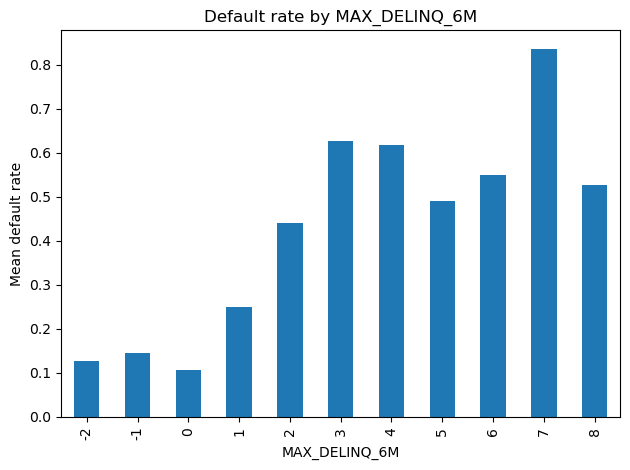

In [21]:
# Default rate for each delinquency-code group
# eg. If a customer's worst delinquency over 6 months is X, what fraction of those customers default?
if pay_cols:
    if target_col in train_df.columns:
        rate = train_df.groupby("MAX_DELINQ_6M")[target_col].mean().sort_index() #for each month, count fauilt then average
        print("\nDefault rate by MAX_DELINQ_6M:\n", rate)
        rate.plot(kind="bar")
        plt.title("Default rate by MAX_DELINQ_6M")
        plt.xlabel("MAX_DELINQ_6M")
        plt.ylabel("Mean default rate")
        plt.tight_layout()
        plt.show()

/var/folders/l3/h_6r_m710z53hjgx6m6hp7wh0000gn/T/ipykernel_14399/691342262.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Default (0)", "Default (1)"])


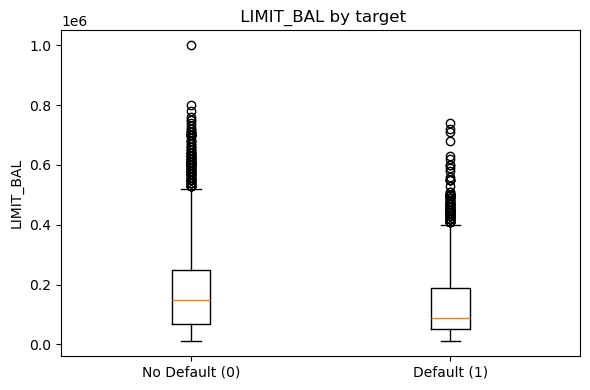

/var/folders/l3/h_6r_m710z53hjgx6m6hp7wh0000gn/T/ipykernel_14399/691342262.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Default (0)", "Default (1)"])


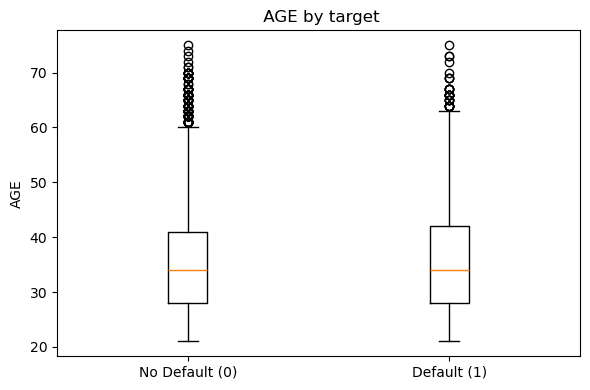

/var/folders/l3/h_6r_m710z53hjgx6m6hp7wh0000gn/T/ipykernel_14399/691342262.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Default (0)", "Default (1)"])


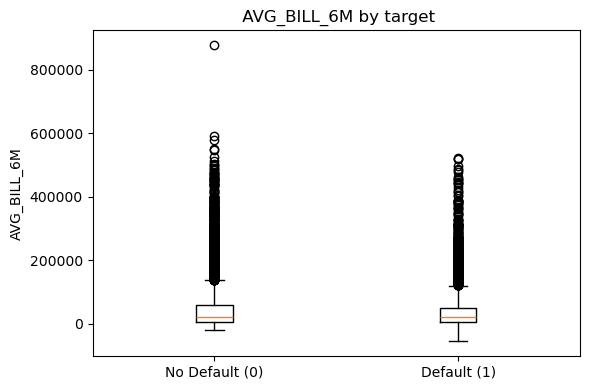

/var/folders/l3/h_6r_m710z53hjgx6m6hp7wh0000gn/T/ipykernel_14399/691342262.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Default (0)", "Default (1)"])


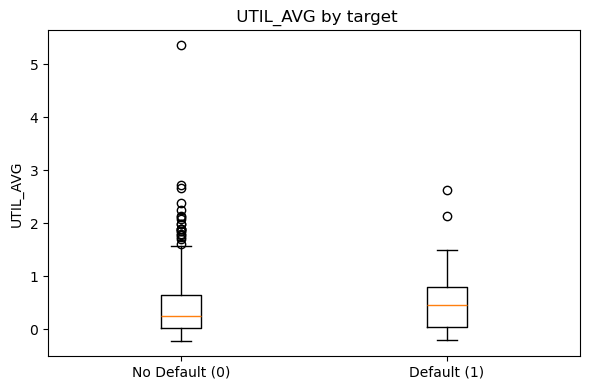

/var/folders/l3/h_6r_m710z53hjgx6m6hp7wh0000gn/T/ipykernel_14399/691342262.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["No Default (0)", "Default (1)"])


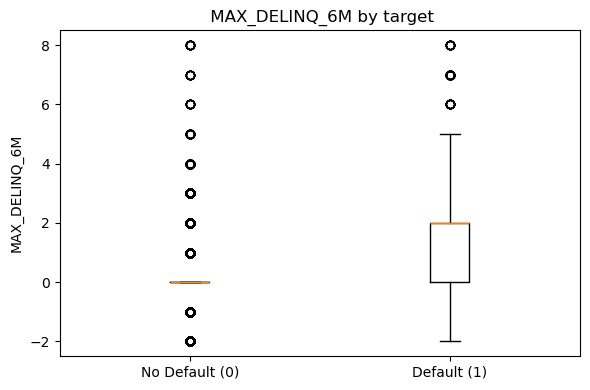

In [22]:
# BILL_AMT* and PAY_AMT* (time-window amounts)
bill_cols = [c for c in train_df.columns if c.startswith("BILL_AMT")]
payamt_cols = [c for c in train_df.columns if c.startswith("PAY_AMT")]

if bill_cols:
    train_df["AVG_BILL_6M"] = train_df[bill_cols].mean(axis=1)
    train_df["SUM_BILL_6M"] = train_df[bill_cols].sum(axis=1)

if payamt_cols:
    train_df["AVG_PAY_6M"] = train_df[payamt_cols].mean(axis=1)
    train_df["SUM_PAY_6M"] = train_df[payamt_cols].sum(axis=1)

# Utilization proxy: average bill / limit (watch divide-by-zero) - risk stress
if "LIMIT_BAL" in train_df.columns and bill_cols:
    train_df["UTIL_AVG"] = train_df["AVG_BILL_6M"] / train_df["LIMIT_BAL"].replace(0, np.nan)

# Plot relationship with target
if target_col in train_df.columns:
    key_vars = [c for c in ["LIMIT_BAL", "AGE", "AVG_BILL_6M", "AvG_PAY_6M", "UTIL_AVG", "MAX_DELINQ_6M"] if c in train_df.columns]
    for c in key_vars:
        # boxplot by default class (0/1)
        data0 = train_df.loc[train_df[target_col] == 0, c].dropna()
        data1 = train_df.loc[train_df[target_col] == 1, c].dropna()

        plt.figure(figsize=(6,4))
        plt.boxplot([data0, data1], labels=["No Default (0)", "Default (1)"])
        plt.title(f" {c} by {target_col}")
        plt.ylabel(c)
        plt.tight_layout()
        plt.show()




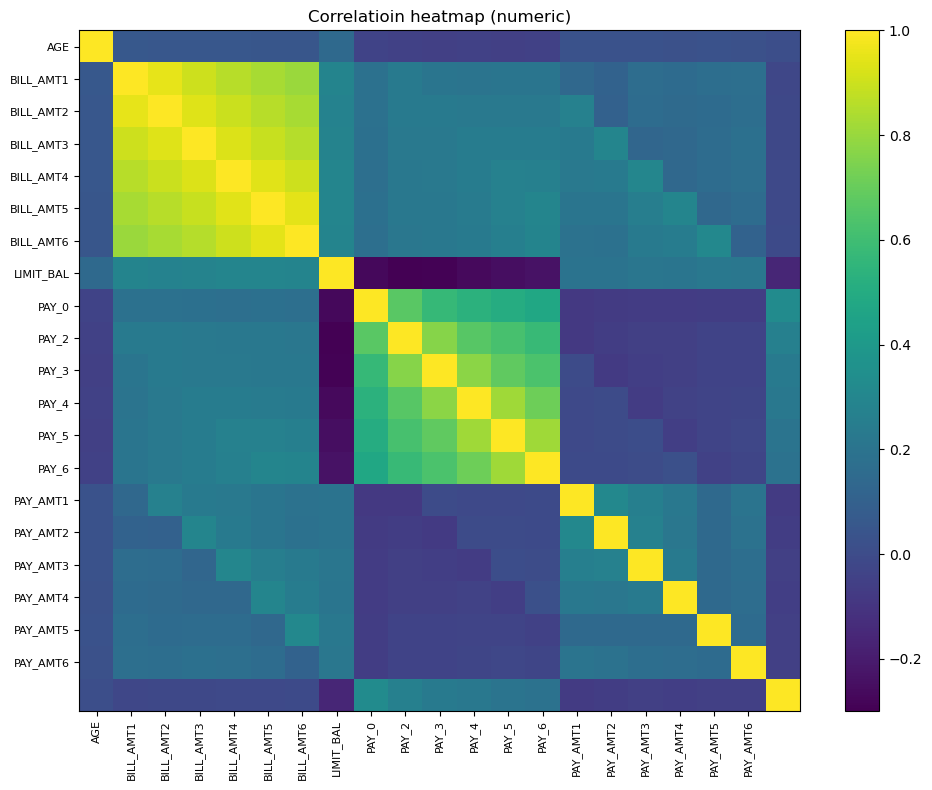

In [23]:
# Correlation 
# If many columns, focus on a manageable subset
corr_cols = [c for c in num_cols if c!="ID" and c in train_df.columns]
corr_for = corr_cols + ([target_col] if target_col in train_df.columns else [])
corr = train_df[corr_for].corr(numeric_only=True)
plt.figure(figsize=(10,8))
plt.imshow(corr, aspect="auto") 
plt.title("Correlatioin heatmap (numeric)")
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90, fontsize=8)
plt.yticks(range(len(corr_cols)), corr_cols, fontsize=8)
plt.colorbar()
plt.tight_layout()
plt.show()

- BILL_AMT1 - BILL_AMT6 block is very bright - Customers who have a high bill in one month usually also have high bills in nearby months. This is expected because balances tend to be persistent. 
- PAY_0 and PAY_6 - also strongly correlated across months with similar reason - someone late one month is often late in adjacent months. 
_ LIMIT_BAL
    - Positive corr with BILL_AMT* (limit and bals tend to scale together) (high limit = high spending)
    - Negative corr with PAY_* (higher llimits tend to be assoicated with lower delinquency codes (less severe lateness), on average).

In [24]:
#Correlation with target
if target_col in train_df.columns:
    target_corr = corr[target_col].sort_values(ascending=False)
    print("\nTop correlations with target:\n", target_corr.head(15))
    print("\nBottom correlations with target:\n", target_corr.tail(15))


Top correlations with target:
 target       1.000000
PAY_0        0.327671
PAY_2        0.265527
PAY_3        0.238930
PAY_4        0.220063
PAY_5        0.203260
PAY_6        0.188717
AGE          0.012830
BILL_AMT6   -0.008177
BILL_AMT5   -0.009710
BILL_AMT4   -0.013726
BILL_AMT2   -0.018048
BILL_AMT3   -0.018280
BILL_AMT1   -0.022720
PAY_AMT5    -0.052609
Name: target, dtype: float64

Bottom correlations with target:
 PAY_6        0.188717
AGE          0.012830
BILL_AMT6   -0.008177
BILL_AMT5   -0.009710
BILL_AMT4   -0.013726
BILL_AMT2   -0.018048
BILL_AMT3   -0.018280
BILL_AMT1   -0.022720
PAY_AMT5    -0.052609
PAY_AMT6    -0.053280
PAY_AMT3    -0.053863
PAY_AMT4    -0.055313
PAY_AMT2    -0.065078
PAY_AMT1    -0.073441
LIMIT_BAL   -0.160995
Name: target, dtype: float64


## Day 52 - Data Cleaning + Features
- Handle missing values
- Encoding
- Scaling

In [25]:
df_new.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64

In [26]:
# preprocessing pipeline

numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, num_cols),
        ("cat", categorical_preprocess, cat_like),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

## Day 53 - Modeling
- Train classical + deep models
    - Baseline: Logistic Regression (common in credit scoring)
    - Strong tabular model: HistGradientBoosting (fast, good baseline)
- tune typerparameters

In [27]:
lr = LogisticRegression(
    max_iter=500, 
    class_weight="balanced", # useful if target is imbalanced
    solver = "liblinear",
    random_state=RANDOM_STATE
)

hgb = HistGradientBoostingClassifier(
    max_depth=None, 
    learning_rate=0.06,
    max_iter=500,
    random_state=RANDOM_STATE
)

pipe_lr = Pipeline(steps=[("prep", preprocess), ("model", lr)])
pipe_hgb = Pipeline(steps=[("prep", preprocess), ("model", hgb)])


# Day 54 - Evaluation
- Compare Performance
- ROC/PR plots
- Interpret

### ROC/PR Plots

In [28]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision", 
    "brier": "neg_brier_score"
}

def cv_report(estimator, name:str):
    out = cross_validate(estimator, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    roc = out["test_roc_auc"].mean()
    pr = out["test_pr_auc"].mean()
    brier = (-out["test_brier"]).mean() # Sklearn rule: higher is better; brier score is a loss
    print(f"{name} | CV ROC-AUC={roc:.4f} | CV PR-AUC={pr:.4f} | CV Brier={brier:.4f}")
    return {"name": name, "cv_roc_auc": roc, "cv_pr_auc": pr, "cv_brier": brier}

cv_lr = cv_report(pipe_lr, "LogReg")
cv_hgb = cv_report(pipe_hgb, "HistGB")

# Pick a "best" model by ROC-AUC (you can switch to PR-AUC depending on imbalance)
best_pipe = pipe_hgb if cv_hgb["cv_roc_auc"] >= cv_lr["cv_roc_auc"] else pipe_lr
best_name = "HistGB" if best_pipe is pipe_hgb else "LogReg"

print("Selected:", best_name)




LogReg | CV ROC-AUC=0.7275 | CV PR-AUC=0.5049 | CV Brier=0.2056
HistGB | CV ROC-AUC=0.7834 | CV PR-AUC=0.5632 | CV Brier=0.1335
Selected: HistGB


In [29]:
# Fit best model & evaluate on test
best_pipe.fit(X_train, y_train)
proba_test = best_pipe.predict_proba(X_test)[:,1]

test_roc = roc_auc_score(y_test, proba_test)
test_pr = average_precision_score(y_test, proba_test)
test_brier = brier_score_loss(y_test, proba_test)

print(f"TEST | {best_name} ROC-AUC={test_roc:.4f} | PR-AUC={test_pr:.4f}")

TEST | HistGB ROC-AUC=0.7769 | PR-AUC=0.5504


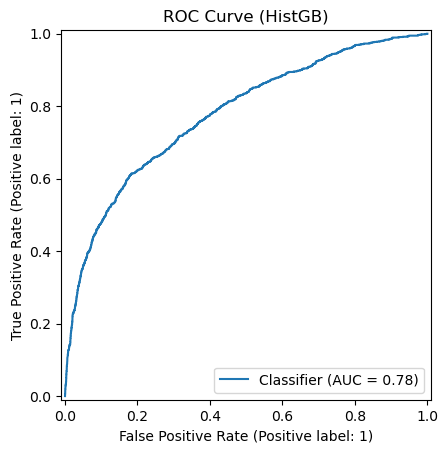

In [30]:
# ROC + PR plots
RocCurveDisplay.from_predictions(y_test, proba_test)
plt.title(f"ROC Curve ({best_name})")
plt.show()



This is a ROC curve for the HistGB classifier. It shows how the model's sensitivity trandes off against false alarms as you vary the decision threshold. 
- X-axis: FPR = FP/ (FP+TN) -- Among actual neg, what fraction did we incorrectly predict as positive?
- Y-axis: TPR (recall / sensitivity) = TP/(TP+FN) -- Among acutal positives, what fraction did we correctly catch?
 
- Curves that bow toward the top-left corner are better (high TPR with low FPR).
- The curve has AUC = 0.78, which generally indicates decent discrimination:
    - Interpretable meaning: if you randomly pick one positive and one negative example, the model will assign a higher score to the positive about 78% of the time.



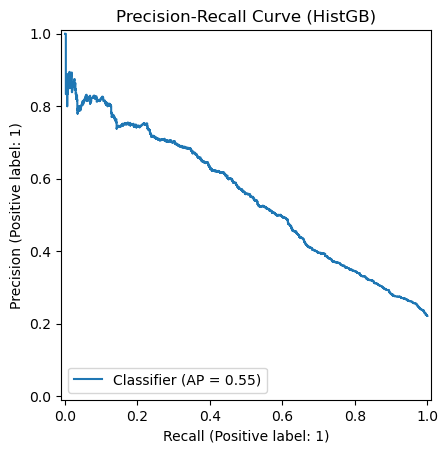

In [31]:
PrecisionRecallDisplay.from_predictions(y_test, proba_test)
plt.title(f"Precision-Recall Curve ({best_name})")
plt.show()

It shows the trade-off between how many positives you catch and how "clean" your positive predictions are as you change the decision threshold. 
- X-axis: recall = TP / (TP+FN) -- Of all actual positives, how many did you detect?
- Y-axis: precision = TP / (TP+FP) -- Of all predicted positives, how many are truly positive?
- Each point corresponds to a different probability threshold:
    - Moving right generally means lowering the threshold → you label more cases as positive → recall increases but precision tends to drop.

- The curve startw with high precision at very low recall
    - The model can identify a small subset of positives with relatively few false positives. 

- AP=0.55
    - AP is the area under the PR curve
    - Higher is better
    - AP is good for imbalanced
    - eg. if only 20% are positive, random guess yields AP=0.2
    - So AP=0.55 suggests your model is meaningfully better than random as long as the positive rate is below 55% (which is common in imbalanced probs)

Pick a threshold
- If false positives are costly → target a region with high precision (upper-left), accept lower recall.
- If missing positives is costly → target higher recall (move right), accept lower precision.


### Calibration

- Calibration (Common requirement in credit risk)
- Calibrate probabilities with isotonic (equally) or sigmoid for smaller data

In [32]:

cal = CalibratedClassifierCV(best_pipe, method="isotonic", cv=3)
cal.fit(X_train, y_train)
proba_cal = cal.predict_proba(X_test)[:,1]

cal_roc = roc_auc_score(y_test, proba_cal)
cal_pr = average_precision_score(y_test, proba_cal)
cal_brier = brier_score_loss(y_test, proba_cal)



In [33]:
from sklearn.metrics import log_loss
# Evaluate calibration-sensitive metrics
print("=== Uncalibrated ===")
print("Brier     :", brier_score_loss(y_test, proba_test))
print("Log loss  :", log_loss(y_test, proba_test))
print("ROC-AUC   :", roc_auc_score(y_test, proba_test))
print("AP (PR-AUC):", average_precision_score(y_test, proba_test))

print("\n=== Isotonic calibrated ===")
print("Brier     :", brier_score_loss(y_test, proba_cal))
print("Log loss  :", log_loss(y_test, proba_cal))
print("ROC-AUC   :", roc_auc_score(y_test, proba_cal))
print("AP (PR-AUC):", average_precision_score(y_test, proba_cal))

=== Uncalibrated ===
Brier     : 0.13551233887920747
Log loss  : 0.4312445551579421
ROC-AUC   : 0.7769303076839469
AP (PR-AUC): 0.5504377866471957

=== Isotonic calibrated ===
Brier     : 0.13535846871495352
Log loss  : 0.43112414813503364
ROC-AUC   : 0.7776973526024779
AP (PR-AUC): 0.55063816201347


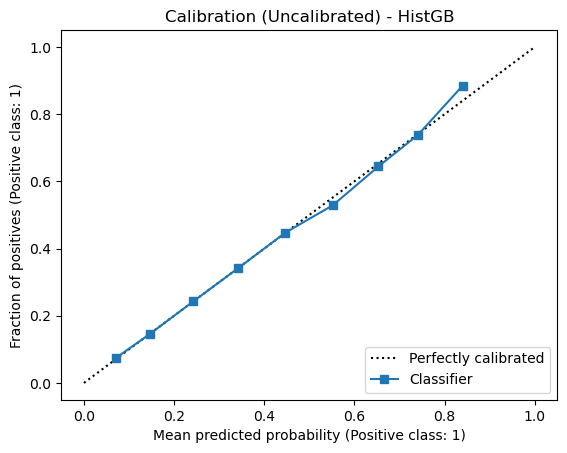

In [34]:
CalibrationDisplay.from_predictions(y_test, proba_test, n_bins=10)
plt.title(f"Calibration (Uncalibrated) - {best_name}")
plt.show()

This is a calibration (reliability) curve for the uncalibrated HistGB probabilities

What the plot represents?
- X-axis: the model's average predicted probability for a bin of samples (eg. all samples where the model predicts around 0.30).
- Y-axis: the actual fraction of positives in that same bin (empirical event rate).
- If a curve lies on the dotted line, then predictions are well-calibrated. 
- The dotted diagonal ("prefectly calibrated") is the idea:     
    -   observed rate ≈ predicted probability
- So if the model predicts 0.3, about 30% should actually be positive. 

How to interpret deviations:
- If the blue curve is above the diagonal:the model is underconfident (true rate> predicted) (predict too low)
- If the blue curve is below the diagonal: the model is overconfident (true rate < predicted) ( predict too high)
- Calibration can't improve ROC-AUC, it mainly improves probability accuracy. 

In this case:
- The blue curve tracks the diagonal closely across most of the range, which indicates good calibration overall, even before explicit calibration. 
- Two small observations:
    - 1n the higher-probability region (roughly 0.75-0.9), the blue points sit slightly above the diagonal. That means the model is a bit underconfident there: when it predicts -0.8, the observed positive rate is a bit higher (closer to -.85-0.9)
    - At the extremes (very low or very high probabilities), curves are often less stable because there are fewer samples in those bins; small sample sizes can move points noticeably. 




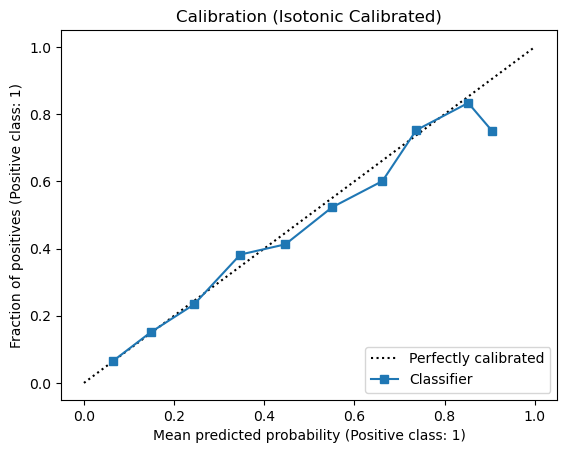

In [35]:
CalibrationDisplay.from_predictions(y_test, proba_cal, n_bins=10)
plt.title("Calibration (Isotonic Calibrated)")
plt.show()

This is the calibration (reliability) curve after isotonic calibration. Interpret it the same way as the uncalibrated plot, but now the probabilities have been post-processed by an isotonic regression mapping. 

In this case
- Across most of the mid-range (roughly 0.1 to 0.85), the points are fairly close to the diagonal, which suggests reasonable calibration there. 
- The key feature is the rightmost region:
    - Around 0.9-1.0 predicted probability, the curve drops below the diagonal (eg. mean prediccted near aroung 0.95 but observed fraction closer to aroung 0.75)
    - This indicates overconfidence at the highest scores after isotonic calibration: when the model says around 95% positive, reality is closer to aroung 75% positive in that bin. 
- Why that happens? (common with isotonic)
    - Isotonic regression is very flexible and can overfit calibration data-especially in the extreme probability bins where there are few sampes. A small number of cases in the top bin can pull the fitted mapping and create artifacts like that end-of-curve dip. 

Takeaways
1. The previous uncalibrated model looked already well-calibrated. In that situation, isotonic can easily make things worse at the extremes. 
2. Or try sigmoid (platt) calibration, which is more constrained and often more stable when data is limited. 
3. Decide using proper metrics on a held-out set:
    - Compare Brier score and/or log loss before vs after calibration. 
    - Also check calibration curve stability (eg. more bins, or bootstrap bands)

When to skip calibration?
1. Reliability curve (uncalibrated) is close to the diagonal across the probability range you care about (yours is). 
2. Brier score / log loss do not improve after calibration (or get worse).
3. Your downstream use is mainly ranking / AUC/ PR-AUC, not interpreting probabilities as literal risks. 


In [36]:
# Try sigmoid calibration
# 1. Fit uncalibrated model
best_pipe.fit(X_train, y_train)

# 2. Calibrate with sigmoid using CV (recommended; avoids leakage)
sig_cal = CalibratedClassifierCV(
    estimator=best_pipe, # base model
    method="sigmoid", # Platt scaling
    cv=5 # 5-fold calibration on training data
)
sig_cal.fit(X_train, y_train)

# 3. Predict probabilities
p_uncal = best_pipe.predict_proba(X_test)[:,1]
p_sig = sig_cal.predict_proba(X_test)[:,1]

# Evaluate calibration-sensitive metrics
print("=== Uncalibrated ===")
print("Brier     :", brier_score_loss(y_test, p_uncal))
print("Log loss  :", log_loss(y_test, p_uncal))
print("ROC-AUC   :", roc_auc_score(y_test, p_uncal))
print("AP (PR-AUC):", average_precision_score(y_test, p_uncal))

print("\n=== Sigmoid calibrated ===")
print("Brier     :", brier_score_loss(y_test, p_sig))
print("Log loss  :", log_loss(y_test, p_sig))
print("ROC-AUC   :", roc_auc_score(y_test, p_sig))
print("AP (PR-AUC):", average_precision_score(y_test, p_sig))


=== Uncalibrated ===
Brier     : 0.13551233887920747
Log loss  : 0.4312445551579421
ROC-AUC   : 0.7769303076839469
AP (PR-AUC): 0.5504377866471957

=== Sigmoid calibrated ===
Brier     : 0.1351074975272202
Log loss  : 0.43022363261497626
ROC-AUC   : 0.7778157998836007
AP (PR-AUC): 0.5560767700201236


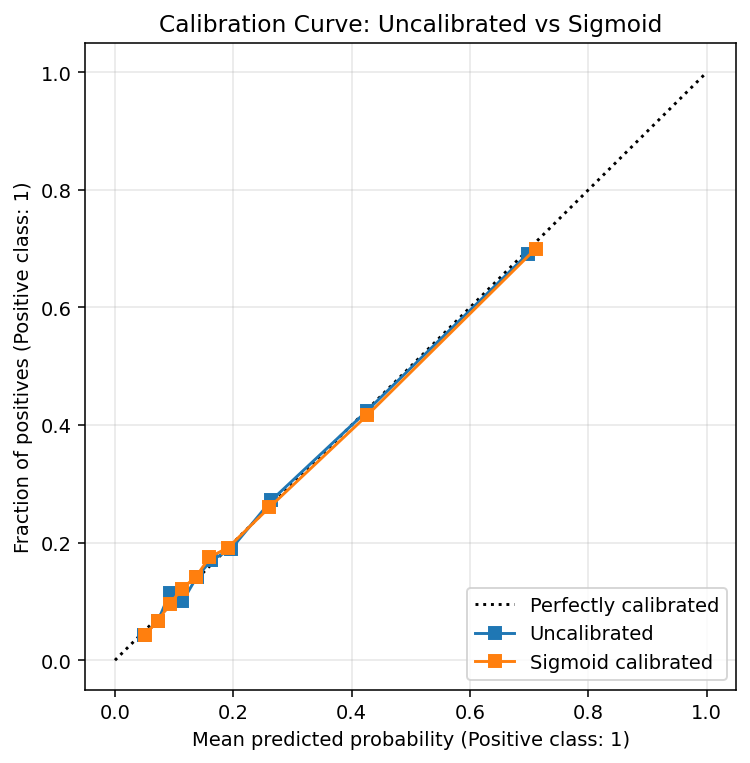

In [37]:
# 5) Plot calibration curves side-by-side
fig, ax = plt.subplots(figsize=(6, 6), dpi=140)
CalibrationDisplay.from_predictions(
    y_test, p_uncal, n_bins=10, strategy="quantile",
    name="Uncalibrated", ax=ax
)
CalibrationDisplay.from_predictions(
    y_test, p_sig, n_bins=10, strategy="quantile",
    name="Sigmoid calibrated", ax=ax
)
ax.set_title("Calibration Curve: Uncalibrated vs Sigmoid")
ax.grid(True, alpha=0.3)
plt.show()

This plot overlays two calibration (reliability) curves:
- Blue = The original HistGB probabilities (uncalibrated)
- Orange = probabilities after sigmoid (Platt) calibration
- Black dotted line = perfect calibration (predicted probability = observed positive rate)

In this case:
1. Both curves track the diagonal very closely. 
    - This means your model's probabilites were already well calibrated, and sigmoid calibration did not change much. 
2. Sigmoid curve is almost on top of uncalibrated.
    - That indicates the fitted sigmoid mapping is close to an "identify" transform (eg. it found little to correct)
3. The model realy outputs probabilites above around 0.7
    - The curves stop around 0.7 on the x-axis, meaning: on this dataset, the classifier is not producing extremely high predicted risks. That can be normal (depends on signal strength, regularization, class overlap), but it also means it can't judge calibration for the 0.9-1.0 range because there is little/no data there. 
4. In this case, calibration is not necessary, sigmoid is better than isotonic. 

### Threshold selection via cost (credit-risk aligned)
- Example: FN (miss a default) is more costly than FP (reject a good client)

- Lower threshold -> more predicted positives -> usually more FP, fewer FN
- Higher threshold -> fewer predicted positives -> usually fewer FP, more FN
- Since the below cost_fn is larger (5.0), the best threshold often shifs lower than 0.5 to avoid expensive FN - depending on the data. 

Best threshold (min expected cost): 0.15


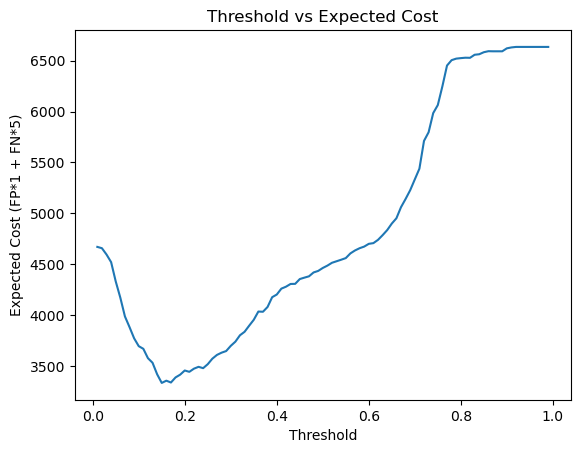

<function matplotlib.pyplot.show(close=None, block=None)>

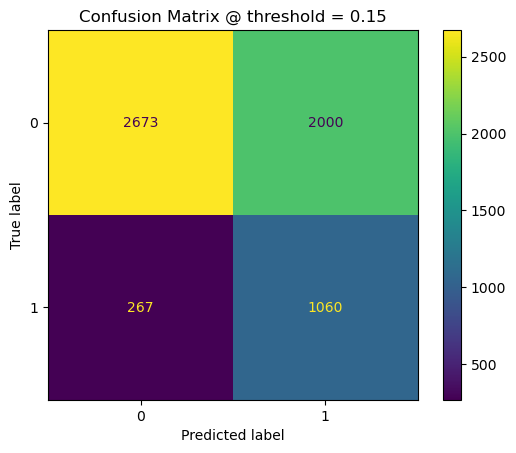

In [38]:
def expected_cost(y_true, proba, threshold, cost_fp=1.0, cost_fn=5.0):
    # proba: predicted prob for class 1 (y_pred)
    # threshold: cutoff used to convert prob into 0 or 1 
    # cost_fp: cost of a fp (false positive: predict 1 when true is 0)
    # cost_fn: cost of a fn (false negative: predict 0 when true is 1)
    y_hat = (proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel() #ravel: flattens 2d matrix into a 1D array
    return cost_fp * fp + cost_fn * fn # total cost

thresholds = np.linspace(0.01, 0.99, 99) # Creates 99 evenly spaced thresholds from 0.01 to 0.99
costs = [expected_cost(y_test, proba_cal, t, cost_fp=1.0, cost_fn=5.0) for t in thresholds] 
best_t = thresholds[np.argmin(costs)] #np.argmin(): find index for smallest cost 

print("Best threshold (min expected cost):", round(float(best_t), 4))

plt.figure()
plt.plot(thresholds, costs)
plt.xlabel("Threshold")
plt.ylabel("Expected Cost (FP*1 + FN*5)")
plt.title("Threshold vs Expected Cost")
plt.show()

y_pred = (proba_cal >= best_t).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix @ threshold = {best_t:.2f}")
plt.show


Interpretation of each cell:
- TN = 2673: True label 0, predicted 0 (correct negatives)
- FP = 2000: True label 0, predicted 1 (false alarms)
- FN = 267: True label 1, predicted 0 (missed positives)
- TP = 1060: True label 1, predicted 1 (caught positives)

Totals:
- True 0 count: 2673 + 2000 = 4673
- True 1 count: 267 + 1060 = 1327
- Total samples: 6000

What this threshold is doing (0.15 is low)
- A low threshold makes it easier to predict “1”, so you typically get:
    - Higher recall (fewer missed positives)
    - More false positives (more false alarms)

You can see that here: the model predicts 1 in (2000 + 1060) = 3060 cases, i.e. 51% of all samples—much higher than the true positive rate (true label 1 prevalence) of 1327/6000 ≈ 22%.

Key performance metrics at this threshold
- Using TN=2673, FP=2000, FN=267, TP=1060:
- Recall / TPR = TP / (TP+FN) = 1060 / 1327 ≈ 79.9%
    - You catch about 80% of true 1’s.
- Precision / PPV = TP / (TP+FP) = 1060 / 3060 ≈ 34.6%
    - Only ~35% of predicted 1’s are truly 1 (lots of false alarms).
-  Specificity / TNR = TN / (TN+FP) = 2673 / 4673 ≈ 57.2%
    - You correctly clear ~57% of true 0’s.
- Accuracy = (TP+TN)/N = (1060+2673)/6000 ≈ 62.2%

If you are using your cost setup (FP=1, FN=5)
- Total expected cost at this threshold would be:
    - Cost = 1·FP + 5·FN = 1·2000 + 5·267 = 3335
    - Average cost per case: 3335/6000 ≈ 0.556

Bottom line
- At threshold = 0.15, the model is tuned to avoid expensive false negatives (missed positives) by predicting “1” more often—resulting in high recall but many false positives (low precision).


### Explainability: Permutation importance on the fitted pipeline

- Permutation_importance expects an estimator with predict/proba;
- We use calibrated model and evaluate importance wrt ROC-AUC using a custom scorer.

In [39]:
#from sklearn.metrics import make_scorer

perm = permutation_importance(
    cal, X_test, y_test, # estimator: calibration; X, y
    scoring="roc_auc",
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

imp = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean, 
    "importance_std": perm.importances_std,
}).sort_values("importance_mean", ascending=False)

print(imp.head(15))


      feature  importance_mean  importance_std
5       PAY_0         0.083137        0.004955
0   LIMIT_BAL         0.018347        0.002557
11  BILL_AMT1         0.015230        0.001237
18   PAY_AMT2         0.007052        0.001541
19   PAY_AMT3         0.006031        0.001609
6       PAY_2         0.005760        0.001227
17   PAY_AMT1         0.004348        0.001691
8       PAY_4         0.003940        0.001483
7       PAY_3         0.003850        0.001216
13  BILL_AMT3         0.003001        0.000885
12  BILL_AMT2         0.002872        0.000645
9       PAY_5         0.002170        0.001549
14  BILL_AMT4         0.002011        0.000697
15  BILL_AMT5         0.001899        0.000911
22   PAY_AMT6         0.001817        0.000790


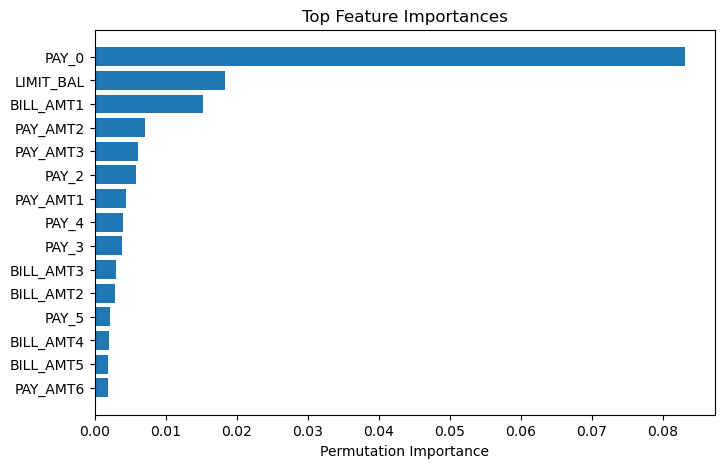

In [40]:
plt.figure(figsize=(8,5))
topk = 15
plt.barh(imp["feature"].head(topk)[::-1], imp["importance_mean"].head(topk)[::-1])
plt.xlabel("Permutation Importance")
plt.title("Top Feature Importances")
plt.show()

### Bootstrap CI for ROC-AUC / PR-AUC 
- It's asking “How stable is my model’s performance, given sampling noise?”
- A single test ROC-AUC (say 0.78) is just one estimate from one finite test sample. Bootstrapping gives you an empirical distribution of that metric and turns it into a confidence interval (CI).

Why is it needed?
- Credit risk models are often used for decisions (approve/decline, pricing, limits). If performance is unstable, then:
    - your chosen cutoff may be brittle,
    - expected losses may vary more than you think,
    - and you may be overfitting to one split.
Bootstrapped CIs give a quick “stability check” without heavy math assumptions.



In [41]:
N_BOOT = 1000
rng = np.random.default_rng(RANDOM_STATE)

def bootstrap_ci(y_true, proba, metric_fn, n_boot=1000, alpha=0.05):
    y_true = np.asarray(y_true)
    proba = np.asarray(proba)
    n = len(y_true)
    stats = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n) # sample with replacement
        # guard against degenerate resamples (all one class)
        if len(np.unique(y_true[idx])) < 2:
            continue
        stats.append(metric_fn(y_true[idx], proba[idx]))
    stats = np.array(stats)
    lo = np.quantile(stats, alpha/2)
    hi = np.quantile(stats, 1 - alpha/2)
    return float(lo), float(hi), float(stats.mean())

roc_ci = bootstrap_ci(y_test, proba_cal, roc_auc_score, n_boot=N_BOOT)
pr_ci = bootstrap_ci(y_test, proba_cal, average_precision_score, n_boot=N_BOOT)

print(f"Bootstrap ROC-AUC mean={roc_ci[2]:.4f}, 95% CI=({roc_ci[0]:.4f}, {roc_ci[1]:.4f})")
print(f"Bootstrap PR-AUC  mean={pr_ci[2]:.4f}, 95% CI=({pr_ci[0]:.4f}, {pr_ci[1]:.4f})")



Bootstrap ROC-AUC mean=0.7779, 95% CI=(0.7635, 0.7931)
Bootstrap PR-AUC  mean=0.5509, 95% CI=(0.5196, 0.5797)


Interpretation: if you repeated this modeling/evaluation on similar samples from the same population, your ROC-AUC would typically fall in about 0.75–0.81. 
- Narrow CI = stable; wide CI = uncertain.

Cross Validation vs Bootstrap
- CV estimates expected performance across different training splits.
- Bootstrap on the test set estimates uncertainty of the metric on the evaluation sample you have.


## Day 55 - Report + Slides
- Write report.md
- Create presentation slides

In [ ]:
'''
joblib.dump(cal, "credit_risk_calibrated_model.joblib")

metrics = {
    "selected_model": best_name,
    "test": {
        "roc_auc_uncal": float(test_roc),
        "pr_auc_uncal": float(test_pr),
        "brier_uncal": float(test_brier),
        "roc_auc_cal": float(cal_roc),
        "pr_auc_cal": float(cal_pr),
        "brier_cal": float(cal_brier),
        "best_threshold_cost": float(best_t),
        "bootstrap_roc_auc_ci95": [roc_ci[0], roc_ci[1]],
        "bootstrap_pr_auc_ci95": [pr_ci[0], pr_ci[1]],
    }
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved: credit_risk_calibrated_model.joblib, metrics.json")
'''

Saved: credit_risk_calibrated_model.joblib, metrics.json
